# Fast Directional Radiosity

This examples shows a simple diffuse simulation of a shoebox room and compare the the result with the analytical solution.
First we import all our dependencies.

In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib ipympl

Lets define our room and source position.

In [2]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 1
ir_length_s = 1
time_resolution = 1/1000
max_order_k = 50
speed_of_sound = 343.2
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = np.array([2, 3, 2])

Let's create the instance of the simulation class called ``DirectionalRadiosityFast`` from the previously defined walls.

In [3]:
# create object
radiosity_fast = sp.DirectionalRadiosityFast.from_polygon(walls, patch_size)


Now we define the scattering coefficient to be 1 for each wall:

In [4]:
# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1, weights=1)
receivers = pf.Coordinates(0, 0, 1, weights=1)
frequencies = np.array([1000])
brdf = sp.brdf.create_from_scattering(
    sources, receivers, pf.FrequencyData(1, frequencies))

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), brdf, sources, receivers)

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_30800/2190615864.py:9: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


The air attenuation and absorption can be defined as well.

In [5]:
# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(brdf.frequencies),
        brdf.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(brdf.frequencies)+absorption,
        brdf.frequencies))


Now the simulation start, first the geometry is baked, where all patch to patch relationships are precalculated. E.g. Form-factor including the geometrical relationship between the patches as well as the BRDFs. This is the most heavy part of the simulation and is independent of the source and receiver position.

In [6]:
# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(ff_method="universal",algorithm="order")


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/anne/git/_pyfar/sparrowpy/sparrowpy/radiosity_fast/form_factor.py:208: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factors[i,j] = calc_form_factor(


Afterwards the source energy is initialized.

In [7]:

radiosity_fast.init_source_energy(source_pos,ff_method="universal",algorithm="order")

Next we calculate the energy exchange between the patches, then we can collect the energy at the receiver.

In [8]:
radiosity_fast.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        histogram_time_resolution=time_resolution,
        histogram_length=ir_length_s, algorithm="order",
        max_depth=max_order_k )

The energy is collected at the receiver, this is quite fast and can be done for as many receivers as required.

In [9]:

ir_fast = np.sum(radiosity_fast.collect_receiver_energy(
    receiver_pos=receiver_pos,
    speed_of_sound=speed_of_sound,
    histogram_time_resolution=time_resolution,
    propagation_fx=True,
    ),axis=1)[0]
n_samples = ir_fast.shape[-1]
reverberation_fast = pf.TimeData(ir_fast, np.arange(n_samples)*time_resolution)

print(reverberation_fast)

TimeData:
(1,) channels with 1000 samples


To compare our energy time curve, we can calculate the analytical solution based on the diffuse sound field in the room after Kuttruff.

In [10]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h:.1f}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT:.2f}s')
E_reverb_analytical = 4/A
t = reverberation_fast.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.TimeData(reverberation_analytic, t)

reverberation distance is 0.5m
reverberation time is 1.24s


Lets compare these to results.

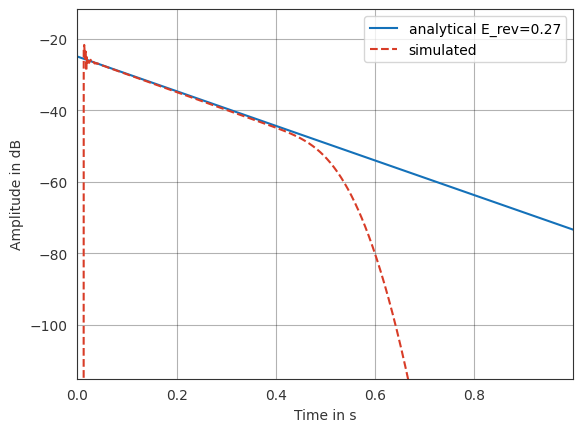

In [11]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')

pf.plot.time(
    reverberation_fast, dB=True, log_prefix=10,
    label='simulated',
    linestyle='--')

plt.legend()
plt.show()

If the order would be increased, this would match even after 0.5s.


In [12]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.10.0
sparrowpy : 0.1.0
numpy     : 1.26.4
pyfar     : 0.7.1

